# OIFS template for plotting
Wrapper around the tripyview package https://github.com/FESOM/tripyview and utilizing plotting function. Works with v0.3.0

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#___________________________________________________________________________________________________________________
import os
import tripyview as tpv
import numpy     as np
import xarray    as xr
import time      as clock
import warnings
xr.set_options(keep_attrs=True)
client_runs   = False

import cartopy.feature as cfeature
from IPython.display import clear_output
import sys
sys.path.insert(1, '/home/a/a270205/PhD-Project/PlotScripts/FESOM/')
import my_functions as mf

/home/a/a270205/tripyview


### Define Parameters

In [2]:
# parameters
#___Dask Client Parameters____________________________________________________________
do_papermill      = False
do_parallel       = True
parallel_tnprc    = 128                          # total number of available CPUs
parallel_nprc     = 20                           # number of dask workers
parallel_nprc_bin = parallel_tnprc-parallel_nprc # number of processor used to parallize the binning loop
parallel_tmem     = 50                           # max. available RAM

#___Save Path_________________________________________________________________________
save_path         = '.' #'~/figures/test_papermill/'
save_fname        = None # filename from papermill come in through save_fname
tripyrun_name     = None # papermill workflow name of notebook 
tripyrun_analysis = None # papermill diagnostic driver
tripyrun_spath_nb = None # papermill path to processed notebooks
tripyrun_spath_fig= None # papermill path to processed figures

#___Data Path & Input Names___________________________________________________________
input_paths= list()
input_paths.append('/work/ba1407/a270205/runtime/awicm3-v3.1/319P7CM31/outdata/oifs')
input_paths.append('/work/ba1407/a270205/runtime/awicm3-v3.1/319P8CM31/outdata/oifs')
input_paths.append('/work/ba1407/a270205/runtime/awicm3-v3.1/319P13CM31/outdata/oifs')

input_names= list()
input_names.append('MH (OSU)')
input_names.append('MH (CSU)')
input_names.append('MH (OSU,fix)')

data_freq = '1d'
vname     = '2t'
year      = [1920, 1929]
mon       = None
day       = None
record    = None 
box       = None
depth     = None

#___Define Reference Data, Year, Mon ...______________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None # '/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/'
ref_name  = None # 'TKE'
ref_year  = None #[1979, 2019]
ref_mon   = None
ref_day   = None
ref_record= None

#___Define Climatology________________________________________________________________
which_clim= 'phc3'
clim_path = '/work/ab0246/a270092/input/fesom2//hydrography/phc3.0_annual.nc'

#___Define Colormap Parameters________________________________________________________
# papermill doesnt like multi variable alignment in a single line
cstr      = 'blue2red'
cnum      = 15
cref      = None
crange    = None
cmin      = None
cmax      = None
cfac      = None
climit    = None
chist     = True
ctresh    = 0.995

ref_cstr  = 'wbgyr'
ref_cnum  = 15
ref_cref  = None
ref_crange= None
ref_cmin  = None
ref_cmax  = None
ref_cfac  = None
ref_climit= None
ref_chist = True
ref_ctresh= 0.995

#___Define Plot Parameters____________________________________________________________
ncol              = 2      # number of pannel columns in figure
nrow              = None
proj              = 'pc' 
box               = [-180, 180, -90, 90]
do_plt            = 'tcf'  # plot pcolor (tpc) or contourf (tcf)
plt_contb         = False   # background contour line (thin)
plt_contf         = True  # contour line of main colorbar steps 
plt_contr         = False  # contour line of reference value 
plt_contl         = True  # label contourline of main colorbar steps 
do_rescale        = None   # rescale dat/work/ab0246/a270092/input/fesom2//hydrography//work/ab0246/a270092/input/fesom2//hydrography/a: None, 'log10', 'slog10', np.array(...)
do_lsm            = None # 'fesom', 'bluemarble', 'etopo', 'stock'
do_mesh           = False, 
mesh_opt          = dict({'color':'k', 'linewidth':0.10})
do_enum           = True  # do enumeration of panels
do_reffig         = False   # plot reference fig when doing anomalies 
do_clim           = True   # plot climatolgy values when doing absoluts
ax_title          = None
cb_label          = None
save_dpi          = 300
save_fmt          = ['png']

In [3]:
# start parallel dask client
if do_parallel and not client_runs:
    from dask.distributed import Client
    
#     # disable dask worker heartbeat --> prevent error ?
#     from dask import config as cfg
#     cfg.set({'distributed.scheduler.worker-ttl': None})
    
    ##import dask
    ## dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
    print(' --> memory_limit: {:3.3f} GB'.format(parallel_tmem/(parallel_nprc)))
    client = Client(n_workers=parallel_nprc, threads_per_worker=1, memory_limit='{:3.3f} GB'.format(parallel_tmem/parallel_nprc))
    client_runs = True
    client

 --> memory_limit: 2.500 GB


/home/a/a270205/.conda/envs/tpvh/lib/python3.8/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41817 instead
  warnings.warn(


In [4]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/a270205/levante-spawner-advanced//proxy/41817/status,
Dashboard: /user/a270205/levante-spawner-advanced//proxy/41817/status,Workers: 20
Total threads: 20,Total memory: 46.57 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35235,Workers: 20
Dashboard: /user/a270205/levante-spawner-advanced//proxy/41817/status,Total threads: 20
Started: Just now,Total memory: 46.57 GiB
Comm: tcp://127.0.0.1:36935,Total threads: 1
Dashboard: /user/a270205/levante-spawner-advanced//proxy/44909/status,Memory: 2.33 GiB
Nanny: tcp://127.0.0.1:41841,


### Process Parameters

In [5]:
cinfo=tpv.set_cinfo(cstr, cnum, crange, cmin, cmax, cref, cfac, climit, chist, ctresh)
ref_cinfo=None
if (ref_path != None): 
    if ref_year   is None: ref_year   = year
    if ref_mon    is None: ref_mon    = mon
    if ref_record is None: ref_record = record
    cinfo['cref']=0.0 
    ref_cinfo=tpv.set_cinfo(ref_cstr, ref_cnum, ref_crange, ref_cmin, ref_cmax, ref_cref, ref_cfac, ref_climit, ref_chist, ref_ctresh)
else:
    do_reffig=False
    
#______________________________________________________________________________________________________    
# concatenate list = list1+list2
if (ref_path != None): 
    if isinstance(ref_path, list): 
        input_paths, input_names = ref_path + input_paths        , ref_name + input_names
    else:    
        input_paths, input_names = list([ref_path]) + input_paths, list([ref_name]) + input_names

### Load Normal Data

In [6]:
ts = clock.time()
data_sets = tpv.open_multiple_data(input_paths, input_names, vname, data_freq, year, mon=mon, day=day, do_load=True, do_zarithm=None,
                                   ref_path=ref_path, do_reffig=do_reffig, ref_year=ref_year, ref_mon=ref_mon, ref_day=ref_day, ref_record=ref_record)
print(' --> elasped time to load data: {:3.2f} min.'.format( (clock.time()-ts)/60  ))

 --> elasped time to load data: 0.69 min.


### Load Concatenated Data

In [7]:
# Manually load Dmitry's concatenated file
year_start = 1920
year_end = 1929
concat_path = '/work/ba1252/a270067/runtime/P15/outdata/oifs'
concat_descript = 'PD (P15)'
concat_filenames = ['P15_1d_2t_1920_2014.nc']

do_reffig = True

In [8]:
data_concat = tpv.open_data(concat_path, vname, 'foobar', years=[year_start, year_end], descript='PD (P15)', do_zarithm=None,
                            file_names=concat_filenames, drop_vars=['time_counter_bnds'], do_load=False, do_tarithm=None,
                            chunks={'time_counter': 35, 'lon': -1, 'lat': -1})
data_concat = data_concat.sel(time=slice(str(year_start), str(year_end)))
data_concat = data_concat.mean(dim='time')

In [9]:
ts = clock.time()
data_concat.load() # 2:30 min (data is 1.5 times as big as data_sets[0]) # 10:45 (auto) # 1:45 (time=150) # 0.35 min (time=35)
print(' --> elasped time to load data: {:3.2f} min.'.format( (clock.time()-ts)/60  ))

 --> elasped time to load data: 0.11 min.


### Do Anomaly

In [10]:
cinfo['cref']=0.0 
ref_cinfo=tpv.set_cinfo(ref_cstr, ref_cnum, ref_crange, ref_cmin, ref_cmax, ref_cref, ref_cfac, ref_climit, ref_chist, ref_ctresh)
data_sets_anom = []
if do_reffig: data_sets_anom.append(data_concat - 273.15) # Convert from K to deg C
for i, ds in enumerate(data_sets):
    ds_anom = tpv.do_anomaly(ds, data_concat)
    data_sets_anom.append(ds_anom)

### Plot Data

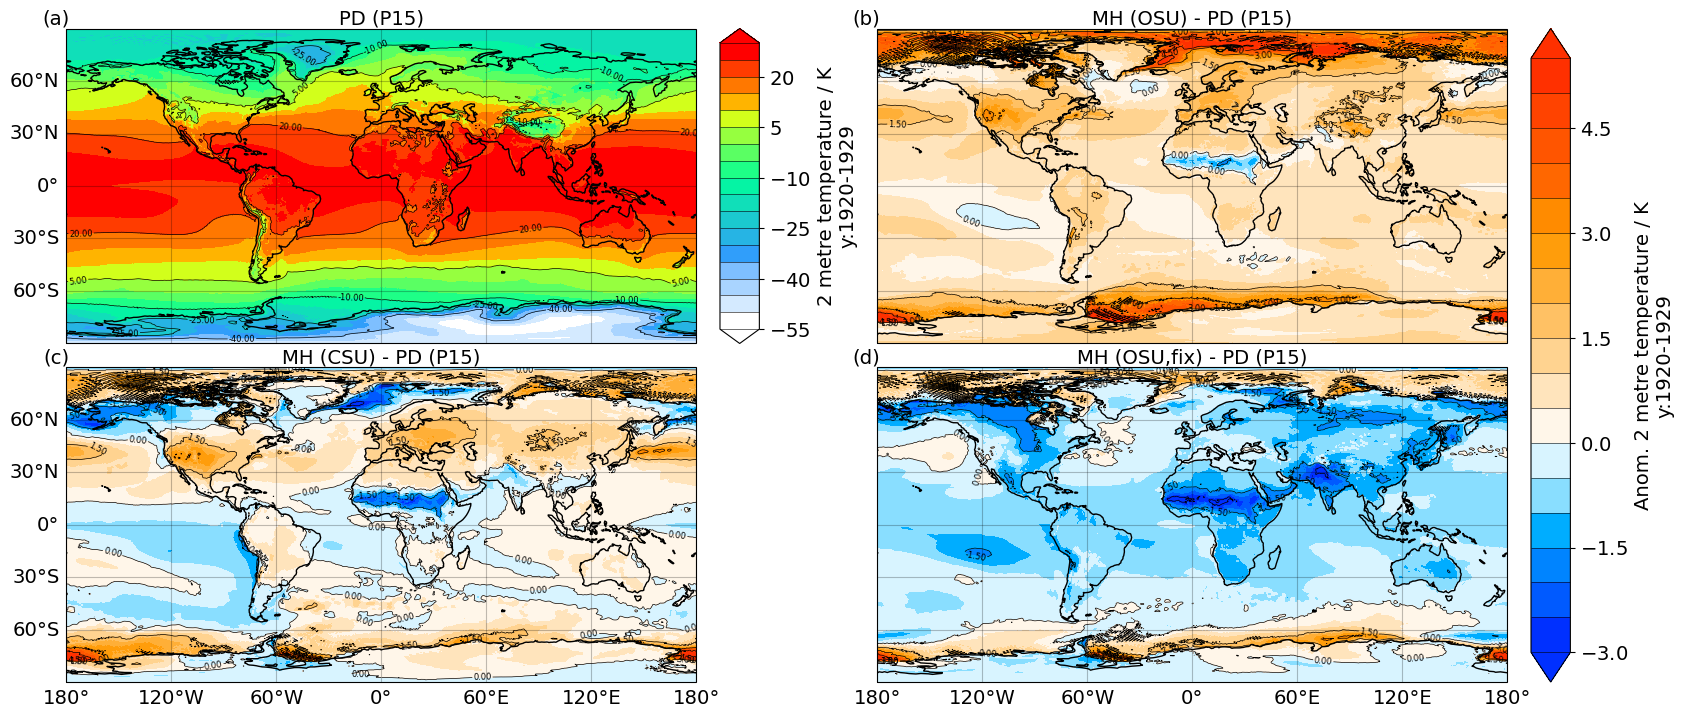

In [11]:
data_sets_plot = data_sets_anom
ndat   = len(data_sets_plot)
if   ncol != None: 
    ncol0  = np.min([ncol,ndat])    
    nrow0  = np.ceil(ndat/ncol0).astype('int')
elif nrow != None: 
    nrow0  = np.min([nrow,ndat])    
    ncol0  = np.ceil(ndat/nrow0).astype('int')
if box is None: box = [-180, 180, -90, 90]


#______________________________________________________________________________________________________
# do colorbar either single cbar or ref_cbar + anom_cbar
if (ref_path != None or concat_path != None) and do_reffig: cb_plt, cb_plt_single, cinfo0 = [1]+[2]*(nrow0*ncol0-1), False, [ref_cinfo.copy(), cinfo.copy()]
else: cb_plt, cb_plt_single, cinfo0 = True, True, cinfo.copy() 


fig, axs, cbar = tpv.plot_hslice(None, data_sets_plot, cinfo=cinfo0, box=box, nrow=nrow0, ncol=ncol0, proj=proj, do_rescale=do_rescale,
                                 do_plt=do_plt, plt_contb=plt_contb, plt_contf=plt_contf, plt_contr=plt_contr, plt_contl=plt_contl, do_enum=do_enum,
                                 ax_opt=dict({'fig_sizefac':2.0, 'cb_plt':cb_plt, 'cb_plt_single':cb_plt_single, 'cb_pos':'vertical', 'cb_h':'auto',}), # 'fs_label':14, 'fs_ticks':14, 'ax_dt':1.0}),
                                 cbl_opt=dict(), cb_label=cb_label, cbtl_opt=dict(),
                                 do_lsm=do_lsm)
# Add continents
for ax in axs:
    #ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.COASTLINE, edgecolor='black')
clear_output(wait=True)
display(fig)

### Save figure

In [12]:
idx=1 if do_clim else 0       
svname = list(data_sets_plot[idx].data_vars)[0]
slabel = data_sets_plot[idx][svname].attrs['str_lsave']

#______________________________________________________________________________________________________
# do save filename path
spath  = save_path
sfpath = None
if spath!=None: 
    sfpath=list()
    name_of_files = list() # multiple for multiple formats
    for sfmt in save_fmt:
        name_of_file = '{:s}_{:s}_{:s}.{:s}'.format(svname, proj, slabel, sfmt)
        name_of_files.append(name_of_file)
        sfpath.append( os.path.join(spath,name_of_file) )
if save_fname!=None: sfpath = [save_fname] # --> needed for diagrun papermille functionality

if save_path is not None:
    for name_of_file in name_of_files:
        mf.Save(save_path, name_of_file, fig.savefig, dpi=save_dpi)